# Testing Code for Missing Pixels task

This is the test code for using the trained models for missing pixels task. Unlike the training code, you can run this code here in Colab.

The training code can be found here (read-only): [Google Colab](https://colab.research.google.com/drive/190PMGtKssth3qN9GOeYAsU3ZZjk2gTVy?usp=sharing).  
The trained models and related files can be found here: [Github](https://github.com/DadangSudadang/missing-pixels-task/).

### Importing libraries and downloading necessary files

In [ ]:
!git clone https://github.com/dmc27/missing_pixels.git
!git clone https://github.com/DadangSudadang/missing-pixels-task.git

fatal: destination path 'missing_pixels' already exists and is not an empty directory.
fatal: destination path 'missing-pixels-task' already exists and is not an empty directory.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

### Loading models

In [ ]:
# Model trained on 200 images
model_200 = load_model("./missing-pixels-task/training_size_200/model_cnn_missingpixel_200Data.h5")

# Model trained on 2K images
model_2K = load_model("./missing-pixels-task/training_size_2K/model_cnn_missingpixel_2KData.h5")

# Model trained on 20K images
model_20K = load_model("./missing-pixels-task/training_size_20K/model_cnn_missingpixel_20KData.h5")

model_200.summary()
# model_2K.summary()
# model_20K.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          640       
                                                                 
 re_lu_3 (ReLU)              (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
 re_lu_4 (ReLU)              (None, 4, 4, 128)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 128)        0         
 2D)                                                  

### Parse the test image


In [ ]:
# STATIC PARAMETERS
BLOCK_SIZE = 8
IMAGE_SIZE = (256, 256)

# target (missing pixel) indices
M1 = 3
M2 = 4

def do_parse_img(img, inps, tgts):
    num_rows = img.shape[0]
    num_cols = img.shape[1]

    for r0 in range(0, num_rows, BLOCK_SIZE):
        for c0 in range(0, num_cols, BLOCK_SIZE):
            # for every 8x8 block segments in the image...

            # get 2d matrices of the input and target
            inp = img[r0:(r0 + BLOCK_SIZE), c0:(c0 + BLOCK_SIZE)].copy() # should be 8, 8
            tgt = img[(r0 + M1):(r0 + M2 + 1), (c0 + M1):(c0 + M2 + 1)].copy() # should be 2, 2

            # set the missing pixel as 0 in input
            inp[M1:(M2 + 1), M1:(M2 + 1)] = np.zeros(tgt.shape)

            # flatten the target from shape of 2, 2 to just 4.
            tgt = tgt.flatten()

            # append to lists of all inputs, normalize to [0, 1]
            inps.append(inp.copy() / 255.0)
            tgts.append(tgt.copy() / 255.0)

img_test_path = "./missing_pixels/balloon.bmp"
img = cv.imread(img_test_path, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

inps = []
tgts = []
do_parse_img(img, inps, tgts)

X_tst, y_tst = np.array(inps), np.array(tgts)

### Generate the image with missing pixels

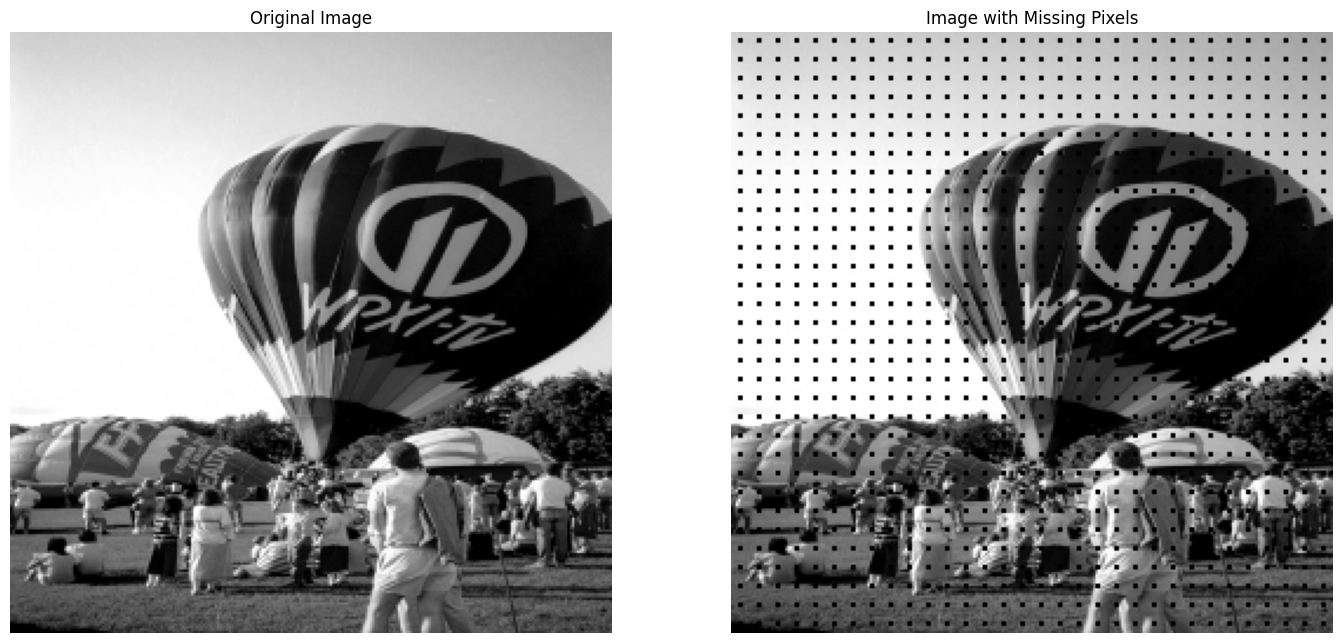

In [ ]:
def is_missing_pixel(r, c):
  return (r >= M1 and c >= M1 and r <= M2 and c <= M2)

def generate_missing_pixel_img(img):
    num_rows = img.shape[0]
    num_cols = img.shape[1]

    missing_pixel_img = np.zeros((num_rows, num_cols))

    for r0 in range(0, num_rows, BLOCK_SIZE):
        for c0 in range(0, num_cols, BLOCK_SIZE):
            # fill in the outer and context pixels
            for r in range(BLOCK_SIZE):
                for c in range(BLOCK_SIZE):
                    assert(r0 + r < num_rows)
                    assert(c0 + c < num_cols)
                    if not is_missing_pixel(r, c):
                        missing_pixel_img[r0 + r, c0 + c] = img[r0 + r, c0 + c]

    return missing_pixel_img


missing_pixel = generate_missing_pixel_img(img)
dpi = 30

fig, axs = plt.subplots(1, 2, figsize=(img.shape[1]*2/dpi, img.shape[0]/dpi), frameon=True)
axs[0].axis('off')
axs[0].set_title("Original Image")
axs[0].imshow(img, cmap="gray", vmin=0, vmax=255)
axs[1].axis('off')
axs[1].set_title("Image with Missing Pixels")
axs[1].imshow(missing_pixel, cmap="gray", vmin=0, vmax=255)
plt.show()

### Predict with the 3 models and show the result

model trained on 200 images
32/32 [==============================] - 1s 13ms/step
MSE              = 9.83343849
MSE (normalized) = 0.00015123

model trained on 2,000 images
32/32 [==============================] - 1s 14ms/step
MSE              = 8.37636137
MSE (normalized) = 0.00012882

model trained on 20,000 images
32/32 [==============================] - 1s 13ms/step
MSE              = 7.46875043
MSE (normalized) = 0.00011486



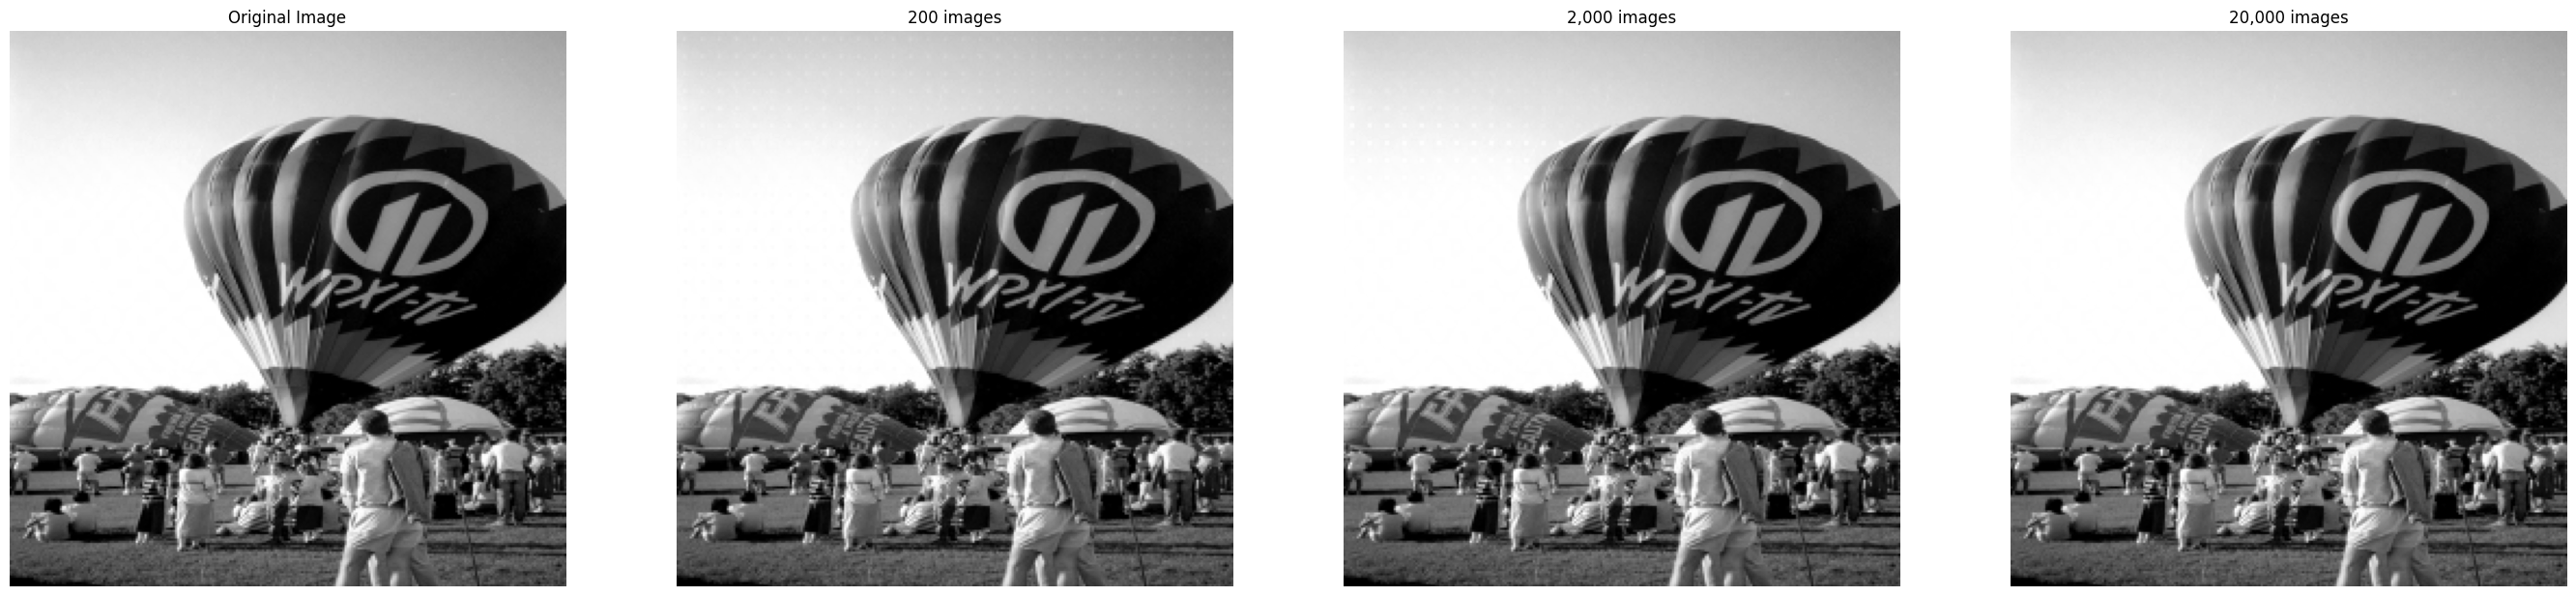

In [ ]:
def generate_predicted_img(missing_pixel_img, y_prd):
    num_rows = missing_pixel_img.shape[0]
    num_cols = missing_pixel_img.shape[1]

    rec_img = missing_pixel_img.copy()
    blk_pos = 0

    for r0 in range(0, num_rows, BLOCK_SIZE):
        for c0 in range(0, num_cols, BLOCK_SIZE):
            out = y_prd[blk_pos]
            pos = 0
            for r in range(BLOCK_SIZE):
                for c in range(BLOCK_SIZE):
                    assert(r0 + r < num_rows)
                    assert(c0 + c < num_cols)
                    if is_missing_pixel(r, c):
                        rec_img[r0 + r, c0 + c] = 255*out[pos]
                        pos += 1
            blk_pos += 1

    return rec_img

# Prediction with model trained on 200 images
print("model trained on 200 images")
y_prd_200 = model_200.predict(X_tst)
rec_img_200 = generate_predicted_img(missing_pixel, y_prd_200)
err_200 = rec_img_200 - img
print("MSE              =", "{:.8f}".format((err_200**2).mean()))
print("MSE (normalized) =", "{:.8f}".format(((err_200/255)**2).mean()))
print("")

# Prediction with model trained on 2,000 images
print("model trained on 2,000 images")
y_prd_2K = model_2K.predict(X_tst)
rec_img_2K = generate_predicted_img(missing_pixel, y_prd_2K)
err_2K = rec_img_2K - img
print("MSE              =", "{:.8f}".format((err_2K**2).mean()))
print("MSE (normalized) =", "{:.8f}".format(((err_2K/255)**2).mean()))
print("")

# Prediction with model trained on 20,000 images
print("model trained on 20,000 images")
y_prd_20K = model_20K.predict(X_tst)
rec_img_20K = generate_predicted_img(missing_pixel, y_prd_20K)
err_20K = rec_img_20K - img
print("MSE              =", "{:.8f}".format((err_20K**2).mean()))
print("MSE (normalized) =", "{:.8f}".format(((err_20K/255)**2).mean()))
print("")

dpi = 30
fig, axs = plt.subplots(1, 4, figsize=(img.shape[1]*4/dpi, img.shape[0]/dpi), frameon=True)

axs[0].axis('off')
axs[0].set_title("Original Image")
axs[0].imshow(img, cmap="gray", vmin=0, vmax=255)

axs[1].axis('off')
axs[1].set_title("200 images")
axs[1].imshow(rec_img_200, cmap="gray", vmin=0, vmax=255)

axs[2].axis('off')
axs[2].set_title("2,000 images")
axs[2].imshow(rec_img_2K, cmap="gray", vmin=0, vmax=255)

axs[3].axis('off')
axs[3].set_title("20,000 images")
axs[3].imshow(rec_img_20K, cmap="gray", vmin=0, vmax=255)

plt.show()

### Plotting the training history

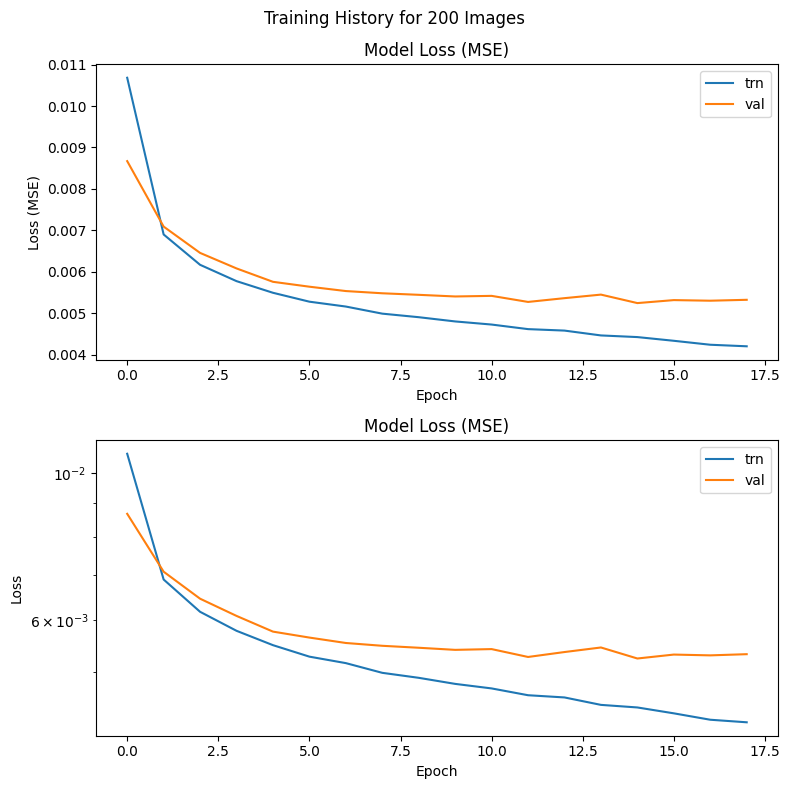

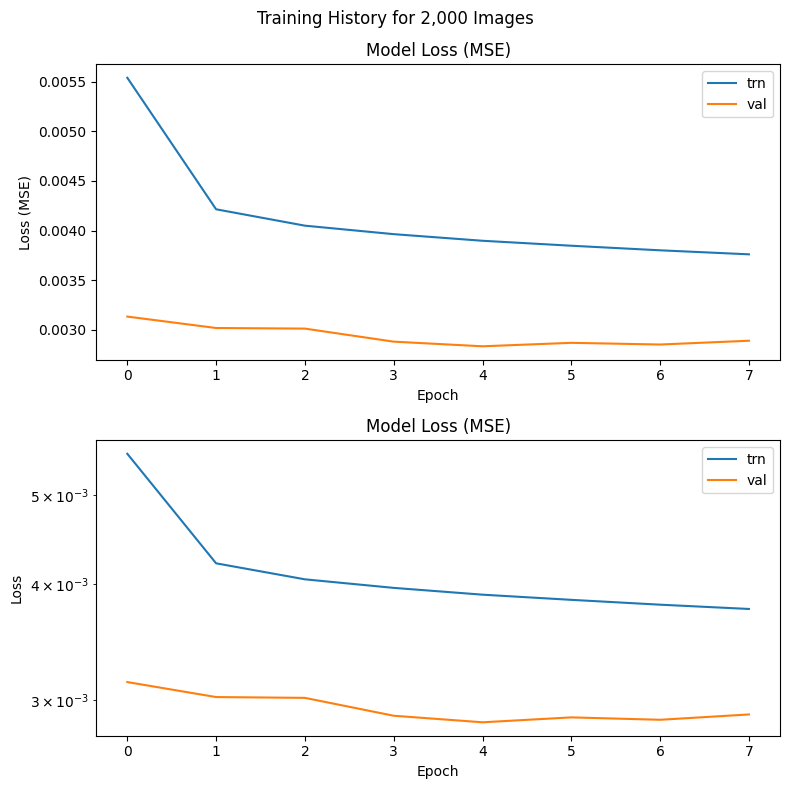

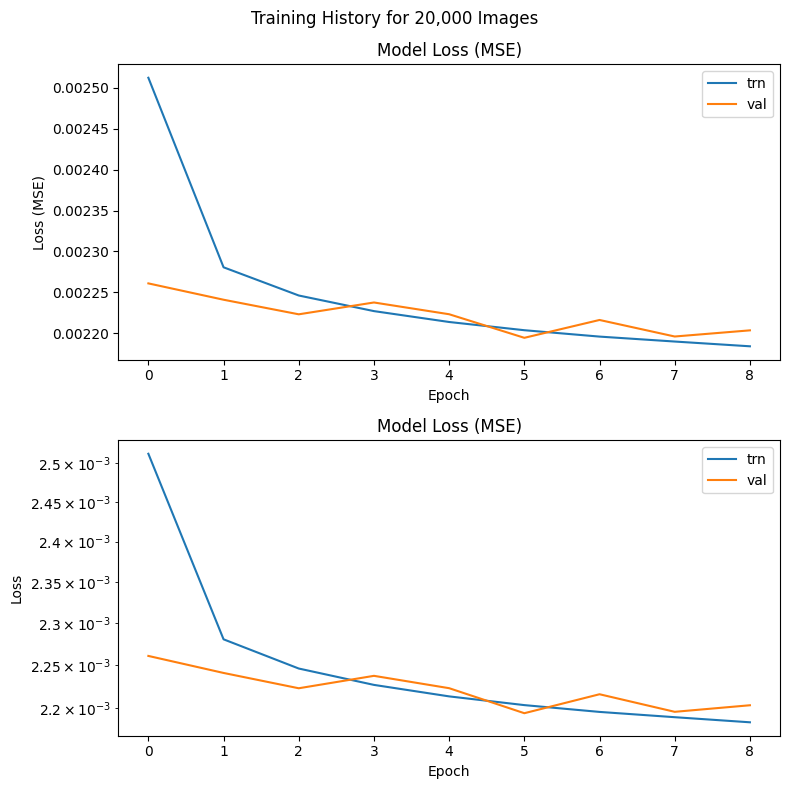

In [ ]:
trn_history_2K = np.load('./missing-pixels-task/training_size_2K/history_2KData.npy',allow_pickle='TRUE').item()
trn_history_20K = np.load('./missing-pixels-task/training_size_20K/history_20KData.npy',allow_pickle='TRUE').item()

def plot_trn_hist(hist, title):
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(title)

    plt.subplot(2,1,1)
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['trn', 'val'], loc='upper right')
    plt.tight_layout()

    plt.subplot(2,1,2)
    plt.semilogy(hist['loss'])
    plt.semilogy(hist['val_loss'])
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['trn', 'val'], loc='upper right')
    plt.tight_layout()

    plt.show()

# 200 images
trn_history_200 = np.load('./missing-pixels-task/training_size_200/history_200Data.npy',allow_pickle='TRUE').item()
plot_trn_hist(trn_history_200, "Training History for 200 Images")

# 2,000 images
trn_history_2K = np.load('./missing-pixels-task/training_size_2K/history_2KData.npy',allow_pickle='TRUE').item()
plot_trn_hist(trn_history_2K, "Training History for 2,000 Images")

# 20,000 images
trn_history_20K = np.load('./missing-pixels-task/training_size_20K/history_20KData.npy',allow_pickle='TRUE').item()
plot_trn_hist(trn_history_20K, "Training History for 20,000 Images")